# bag-of-words + tf-idf  LogisticRegression

In [16]:
import pandas as pd
import numpy as np
import matplotlib as plt
df = pd.read_csv('cnnchile_7000.csv')
df.head()
df = df.drop(['country','media_outlet','url','date'], 1)
df1 = pd.DataFrame({'full text':df['title']+" "+df['text'],'category':df["category"]})

In [17]:
import spacy

nlp = spacy.load('es_core_news_sm')

from sklearn.feature_extraction.text import CountVectorizer

def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticales
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # return preprocessed list of tokens
    return mytokens

## bag-of-words + tf-idf

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

bow_vector = TfidfVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

In [19]:
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer

bow_vector.fit_transform(df1["full text"][0:300].values.astype('U'))

<300x4317 sparse matrix of type '<class 'numpy.float64'>'
	with 17639 stored elements in Compressed Sparse Row format>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df1['full text'].astype('U') 
ylabels = df1['category'].astype('U')
lb = LabelEncoder()
ylabels_encoded = lb.fit_transform(ylabels)
X_train, X_test, y_train, y_test = train_test_split(X, ylabels_encoded, test_size=0.5)

## Logistic Regression


###  Algoritmo a utilizar en el problema de optimización.
####  Solucionador {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, predeterminado = 'lbfgs'
1. Para conjuntos de datos pequeños, 'liblinear' es una buena opción, mientras que 'sag' y 'saga' son más rápidos para los grandes.
    
1. Para problemas multiclase, solo 'newton-cg', 'sag', 'saga' y 'lbfgs' manejan pérdida multinomial; 

1. 'liblinear' se limita a esquemas uno versus resto.

1. 'newton-cg', 'lbfgs', 'sag' y 'saga' manejan L2 o sin penalización

1. 'liblinear' y 'saga' también manejan la penalización L1

1. 'saga' también admite la penalización de 'elasticnet'

1. 'liblinear' no admite la configuración penalty='none'



### penalización 
#### {'l1', 'l2', 'elasticnet', 'none'}, predeterminado = 'l2'
- Se utiliza para especificar la norma utilizada en la penalización. Los solucionadores 'newton-cg', 'sag' y 'lbfgs' solo admiten penalizaciones 12. 'elasticnet' solo es compatible con el solucionador de 'saga'. Si es 'none' (no compatible con el solucionador liblinear), no se aplica la regularización.



### n_jobs int, 
#### predeterminado = Ninguno
- Número de núcleos de CPU utilizados al paralelizar clases si multi_class = 'ovr' ”. Este parámetro se ignora cuando solverse establece en 'liblinear' independientemente de si se especifica o no 'multi_class'. Nonesignifica 1 a menos que esté en un joblib.parallel_backend contexto. -1significa usar todos los procesadores. Consulte el glosario para obtener más detalles.

### Parametros a usar:
En L-BFGS son metodos con un gran numeros de parametros, o de alta complejidad.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

nb = LogisticRegression(solver='newton-cg',n_jobs=-1)
model_nb = Pipeline([('vectorizing', bow_vector),
                 ('learning', nb)])
# model generation
model_nb.fit(X_train.astype('U'), y_train.astype('U'))

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x000002AD8F9E5EE0>)),
                ('learning',
                 LogisticRegression(n_jobs=-1, solver='newton-cg'))])

In [22]:
from sklearn import metrics

predicted = model_nb.predict(X_test.values.astype('U'))
predicted_proba = model_nb.predict_proba(X_test.values.astype('U'))

In [23]:
print("Accuracy:",metrics.accuracy_score(y_test.astype('U'), predicted))

Accuracy: 0.7762857142857142


In [24]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test.astype('U'), predicted)
print(classification_report(y_test.astype('U'), predicted))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       470
           1       0.91      0.89      0.90       503
           2       0.82      0.82      0.82       499
           3       0.80      0.72      0.76       527
           4       0.71      0.73      0.72       497
           5       0.71      0.73      0.72       485
           6       0.66      0.64      0.65       519

    accuracy                           0.78      3500
   macro avg       0.78      0.78      0.78      3500
weighted avg       0.78      0.78      0.78      3500



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

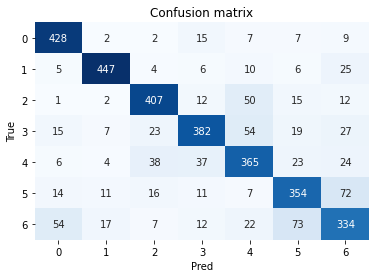

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test.astype('U'), predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)